In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/opt/anaconda3/envs/sentiment-analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

In [3]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [6]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path): 
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
neg: /Users/christianharjuno/Documents/Source Codes/python/sentiment-analysis-test/datasets/aclImdb/train/neg
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsup: /Users/christianharjuno/Documents/Source Codes/python/sentiment-analysis-test/datasets/aclImdb/train/unsup
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /Users/christianharjuno/Documents/Source Codes/python/sentiment-analysis-test/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 

In [7]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
            
    return pd.DataFrame.from_dict(data)

In [8]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
neg
urls_pos.txt
unsup
urls_neg.txt
pos
unsupBow.feat
labeledBow.feat
                                            sentence  sentiment
0  Working with one of the best Shakespeare sourc...          0
1  Well...tremors I, the original started off in ...          0
2  Ouch! This one was a bit painful to sit throug...          0
3  I've seen some crappy movies in my life, but t...          0
4  "Carriers" follows the exploits of two guys an...          0


In [9]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())


neg
urls_pos.txt
urls_neg.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  Alan Rickman & Emma Thompson give good perform...          0
1  I have seen this movie and I did not care for ...          0
2  In Los Angeles, the alcoholic and lazy Hank Ch...          0
3  This film is bundled along with "Gli fumavano ...          0
4  I only comment on really very good films and o...          0


In [10]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

'Sentiments Counts.html'

In [11]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text


In [12]:
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

In [13]:
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

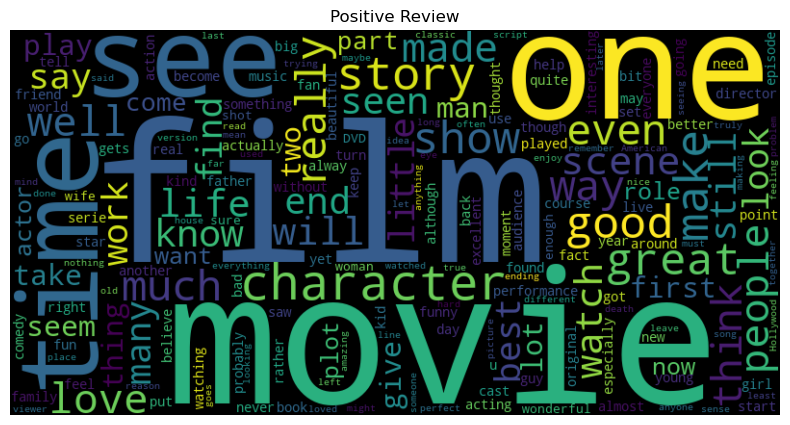

In [14]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

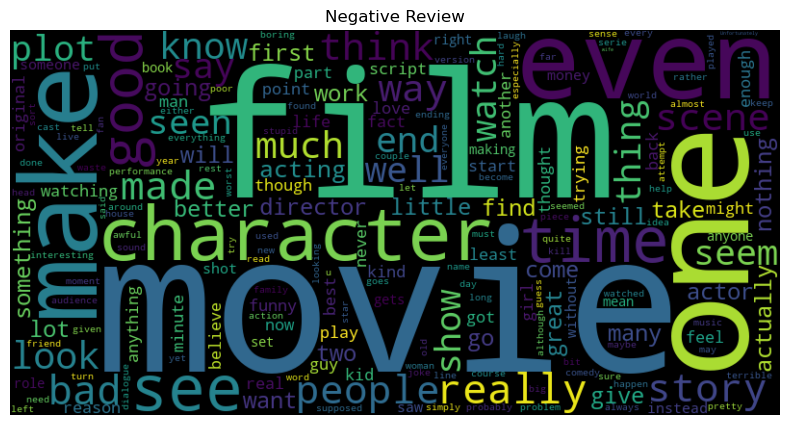

In [15]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [16]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [17]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

2025-04-30 11:09:15.770652: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-30 11:09:15.770798: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-30 11:09:15.770811: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-30 11:09:15.771138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-30 11:09:15.771152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audienceBranagh steals the film from under Fishburne's nose, and there's a talented cast on good form

Input Ids -->>
 tf.Tensor(
[  101  2551  2007  2028  1997  1996  2190  8101  4216  1010  2023  2143
  9020  2000  2022  4923  3085  2000  2009  1005  1055  3120  1010  5819
  2145 16004  2000  1037  7289  4378 10024  2532  5603 15539  1996  2143
  2013  2104  3869  8022  2063  1005  1055  4451  1010  1998  2045  1005
  1055  1037 10904  3459  2006  2204  2433   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0 

In [21]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [23]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


AssertionError: Concurrent access?

In [ ]:
model.save("./final.keras")

/opt/anaconda3/envs/sentiment-analysis/lib/python3.11/site-packages/transformers/generation/tf_utils.py:465: UserWarning:

`seed_generator` is deprecated and will be removed in a future version.



In [30]:
from transformers import TFBertForSequenceClassification

# Step 1: Recreate the model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Step 2: Load weights from the Keras .h5 file (saved from model.save)
model.load_weights("./final.keras")  # path should point to the weights folder


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/sentiment-analysis/lib/python3.11/site-packages/transformers/generation/tf_utils.py:465: UserWarning:

`seed_generator` is deprecated and will be removed in a future version.



In [32]:
model.save_pretrained("pretrained/model")
tokenizer.save_pretrained("pretrained/tokenizer")

('pretrained/tokenizer/tokenizer_config.json',
 'pretrained/tokenizer/special_tokens_map.json',
 'pretrained/tokenizer/vocab.txt',
 'pretrained/tokenizer/added_tokens.json')

In [34]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('pretrained/tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained('pretrained/model')

Some layers from the model checkpoint at pretrained/model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at pretrained/model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [35]:
pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

2025-04-30 11:17:45.758717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 223s 559ms/step
Predicted Label : ['positive', 'Negative', 'positive', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative', 'Negative']
Actual Label    : ['positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative', 'Negative']


In [36]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      6250
    positive       0.88      0.89      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



In [37]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [41]:
Review ='It is not like i never told you before'
Get_sentiment(Review)

1/1 [==============================] - 1s 1s/step


['positive']